In [17]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.0.1+cu117
CUDA version: 11.7


In [18]:
!pip install japanize-matplotlib
!pip install torch-geometric

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import torch
from random import random
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, roc_curve


## 元データの読み込み

In [20]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルの読み込み
df = pd.read_csv('./experiment/dataset/contracts.csv')

# MultiGraphの作成
G = nx.MultiGraph()

# エッジの追加（重複を許可）
for _, row in df.iterrows():
    G.add_edge(row['from_address'], row['to_address'])

# グラフの基本情報を表示
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 312920
Number of edges: 464405


## 実験用データのグラフ分割

In [21]:
""" テストデータのinput(トレインデータ作成用) """
df = pd.read_csv('./experiment/dataset/test_data.csv')

# MultiGraphの作成
G_test = nx.MultiGraph()

# エッジの追加（重複を許可）
for _, row in df.iterrows():
    G_test.add_edge(row['from_address'], row['to_address'])

# グラフの基本情報を表示
print(f"Number of nodes: {G_test.number_of_nodes()}")
print(f"Number of edges: {G_test.number_of_edges()}")

""" トレインデータのinput(テストデータ作成用) """

df = pd.read_csv('./experiment/dataset/train_data.csv')

G_train = nx.MultiGraph()

#エッジの追加
for _, row in df.iterrows():
    G_train.add_edge(row['from_address'], row['to_address'])

print(f"Number of train_nodes: {G_train.number_of_nodes()}")
print(f"Number of test_edges: {G_train.number_of_edges()}")

Number of nodes: 24284
Number of edges: 46441
Number of train_nodes: 295219
Number of test_edges: 417966


### データセット分割

In [22]:
#テストグラフの作成(ノードの数は一緒)
def remove_edges(G, edges_to_remove):
    G.remove_edges_from(edges_to_remove)
    G.remove_edges_from([(v, u) for (u, v) in edges_to_remove])

### 訓練データ

In [23]:
G_train = G.copy()
remove_edges(G_train, list(G_test.edges()))
print(f"Number of nodes: {G_train.number_of_nodes()}")
print(f"Number of edges: {G_train.number_of_edges()}")

Number of nodes: 312920
Number of edges: 412930


### テストデータ

In [24]:
G_test = G.copy()
remove_edges(G_test, list(G_train.edges()))
print(f"Number of test_nodes: {G_test.number_of_nodes()}")
print(f"Number of test_edges: {G_test.number_of_edges()}")

Number of test_nodes: 312920
Number of test_edges: 48344


## 実装

### データセットの加工(ネットワークをFromとToにする)

#### 元グラフのedge_index化

In [25]:
# ノードに整数インデックスを割り当てる
node_to_index = {node: i for i, node in enumerate(G.nodes())}

# エッジリストを整数インデックスに変換
edge_list_int = [(node_to_index[u], node_to_index[v]) for u, v in G.edges()]

print(f"エッジ数：{len(edge_list_int)}")

num_nodes = len(G.nodes)


print(f"ノード数{num_nodes}")

# 整数インデックスのエッジリストをテンソルに変換
edge_index = torch.tensor(edge_list_int, dtype=torch.long).t().contiguous()

print(edge_index)

エッジ数：464405
ノード数312920
tensor([[     0,      0,      0,  ..., 312909, 312913, 312916],
        [     1,    554,    554,  ..., 312910, 312914, 312917]])


#### 学習データのedge_index化

In [26]:
# ノードに整数インデックスを割り当てる
node_to_index = {node: i for i, node in enumerate(G_train.nodes())}

# エッジリストを整数インデックスに変換
edge_list_int = [(node_to_index[u], node_to_index[v]) for u, v in G_train.edges()]

print(f"エッジ数：{len(edge_list_int)}")

num_nodes = len(G_train.nodes)


print(f"ノード数{num_nodes}")

# 整数インデックスのエッジリストをテンソルに変換
train_edge_index = torch.tensor(edge_list_int, dtype=torch.long).t().contiguous()


print(train_edge_index)

エッジ数：412930
ノード数312920
tensor([[     0,      0,      0,  ..., 295168, 295180, 295205],
        [     1,    554,    554,  ..., 295169, 295181, 295206]])


#### テストデータの分割edge_index化

In [27]:
# ノードに整数インデックスを割り当てる
node_to_index = {node: i for i, node in enumerate(G_test.nodes())}

# エッジリストを整数インデックスに変換
edge_list_int = [(node_to_index[u], node_to_index[v]) for u, v in G_test.edges()]

print(f"エッジ数：{len(edge_list_int)}")

num_nodes = len(G_test.nodes)


print(f"ノード数{num_nodes}")

# 整数インデックスのエッジリストをテンソルに変換
test_edge_index = torch.tensor(edge_list_int, dtype=torch.long).t().contiguous()


print(test_edge_index)

エッジ数：48344
ノード数312920
tensor([[     0,      0,      0,  ..., 312909, 312913, 312916],
        [   140,    140,    140,  ..., 312910, 312914, 312917]])


### ベースライン用のグラフの作成

In [48]:
G_base_line = nx.MultiGraph()
G_base_line.add_nodes_from(range(len(G.nodes)))
G_base_line.add_edges_from(edge_index.t().tolist())
G_base_line = nx.Graph(G_base_line)
print(G_base_line)

Graph with 312920 nodes and 333010 edges


### テスト用のグラフを作成

In [49]:
G_base_line_test = nx.MultiGraph()
G_base_line_test.add_nodes_from(range(len(G_train.nodes)))
G_base_line_test.add_edges_from(train_edge_index.t().tolist())
G_base_line_test = nx.Graph(G_base_line_test)
print(G_base_line_test)

Graph with 312920 nodes and 307845 edges


### エッジのインデックスの作成

In [29]:
# 負例のエッジを生成
def generate_negative_edges(G, n_samples, positive_edges):
    negative_edges = []
    positive_edges_set = set(map(tuple, positive_edges))
    
    while len(negative_edges) < n_samples:
        print(len(negative_edges))
        u = np.random.choice(list(G.nodes()))
        v = np.random.choice(list(G.nodes()))
        
        if u != v and (u, v) not in positive_edges_set and (v, u) not in positive_edges_set:
            negative_edges.append([u, v])
    
    return negative_edges

#### 負例のエッジをCSVで作成

In [121]:
pos_edge_index = test_edge_index.t().tolist()

In [144]:
# # 負例のエッジを生成
# negative_edges = generate_negative_edges(G_base_line, len(train_edge_index.t().tolist()), edge_index.t().tolist())
# # データフレームに変換
# df_negative_edges = pd.DataFrame(negative_edges, columns=['u', 'v'])

# # CSVファイルに保存
# df_negative_edges.to_csv('GCN_negative_edge.csv', index=False, header=True)

In [44]:
# CSVファイルを読み込む
df_negative_edges = pd.read_csv('./experiment/dataset/negative_edges.csv')

# リストに変換
negative_edges = df_negative_edges.values.tolist()

In [46]:
pos_edge_index = test_edge_index.t().tolist()
neg_edge_index = negative_edges
print(f"エッジ数：{len(pos_edge_index)}, エッジ；{pos_edge_index}")
print(f"エッジ数：{len(neg_edge_index) }, エッジ；{neg_edge_index}")

## 共通の隣人

#### ROC-AUC値

ROC-AUC: 0.4100


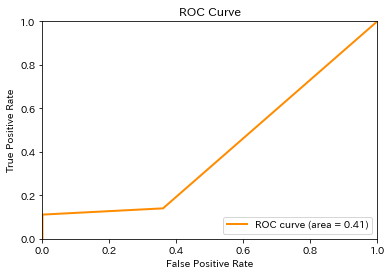

In [53]:
def predict_links_normalized_common_neighbors(G, pos_edge_index, neg_edge_index):
    predictions = []
    labels = []
    
    # 正例の予測
    for u, v in pos_edge_index:
        common_neighbors = list(nx.common_neighbors(G, u, v))
        score = len(common_neighbors)
        predictions.append(score)
        labels.append(1)  # 正例のラベルは1
    
    # 負例の予測
    for u, v in neg_edge_index:
        common_neighbors = list(nx.common_neighbors(G, u, v))
        score = len(common_neighbors)
        predictions.append(score)
        labels.append(0)  # 負例のラベルは0
        
    predictions = np.array(predictions)
    if len(predictions) > 0:
        """ 
            正規化
        """
        predictions = (predictions - predictions.min()) / (predictions.max() - predictions.min()) 
    return predictions, labels


# 予測と評価
predictions, labels = predict_links_normalized_common_neighbors(G_base_line_test, pos_edge_index, neg_edge_index)


roc_auc = roc_auc_score(labels, predictions)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(labels, predictions)

# ROC AUC曲線のプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### F1値

## Jaccard係数

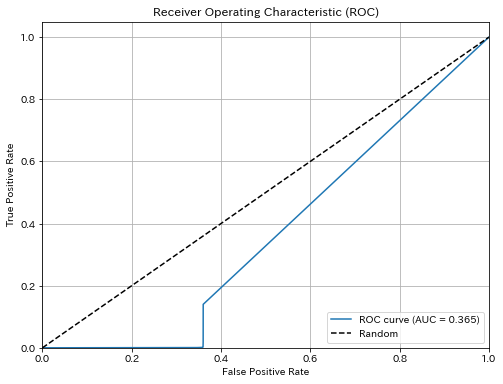

Jaccard Coefficient ROC-AUC: 0.3649


In [80]:
import networkx as nx
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def predict_links_jaccard(G, pos_edge_index, neg_edge_index):
    predictions = []
    labels = []
    
    # 正例の予測
    for u, v in pos_edge_index:
        score = next(nx.jaccard_coefficient(G, [(u, v)]))[-1]
        predictions.append(score)
        labels.append(1)
    
    # 負例の予測
    for u, v in neg_edge_index:
        score = next(nx.jaccard_coefficient(G, [(u, v)]))[-1]
        predictions.append(score)
        labels.append(0)
        
    predictions = np.array(predictions)
    if len(predictions) > 0:
        """ 
            正規化
        """
        predictions = (predictions - predictions.min()) / (predictions.max() - predictions.min()) 
    
    return predictions, labels

def evaluate_and_plot(predictions, labels):
    roc_auc = roc_auc_score(labels, predictions)
    fpr, tpr, _ = roc_curve(labels, predictions)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return roc_auc

predictions, labels = predict_links_jaccard(G_base_line_test, pos_edge_index, neg_edge_index)
roc_auc = evaluate_and_plot(predictions, labels)
print(f'Jaccard Coefficient ROC-AUC: {roc_auc:.4f}')


## Adamic/Adar係数

ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ROC-AUC: 0.41


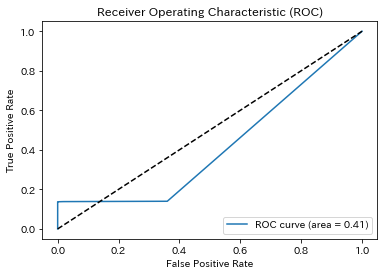

In [82]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


# NetworkXの組み込みAdamic-Adar指数を使用
def predict_links_adamic_adar(G, pos_edge_index, neg_edge_index):
    predictions = []
    labels = []
    
    # 正例の予測
    for u, v in pos_edge_index:
        try:
            score = next(nx.adamic_adar_index(G, [(u, v)]))[-1]
            predictions.append(score)
        except ZeroDivisionError:
            print("ZeroDivisionError")
            predictions.append(0)
        
        labels.append(1)
    
    # 負例の予測
    for u, v in neg_edge_index:
        try:
            score = next(nx.adamic_adar_index(G, [(u, v)]))[-1]
            predictions.append(score)
        except ZeroDivisionError:
            print("ZeroDivisionError")
            predictions.append(0)

        labels.append(0)
    
    # predictions = np.array(predictions)
    # if len(predictions) > 0:
    #     """ 
    #         正規化
    #     """
    #     predictions = (predictions - predictions.min()) / (predictions.max() - predictions.min()) 

    return predictions, labels

predictions, labels = predict_links_adamic_adar(G_base_line_test, pos_edge_index, neg_edge_index)
# ROC-AUCの計算と描画
roc_auc = roc_auc_score(labels, predictions)
fpr, tpr, _ = roc_curve(labels, predictions)

print(f"ROC-AUC: {roc_auc:.2f}")

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

45.973853473257236


## Prefential Attachment

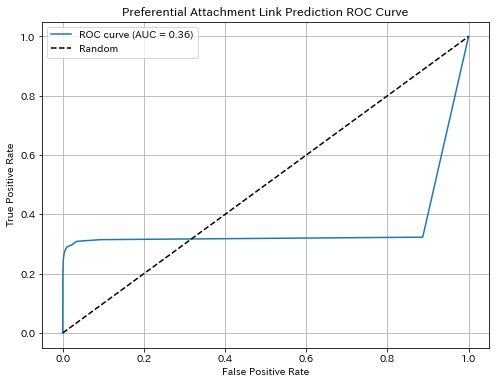

In [93]:
def Prefentisal_Attachment_link_prediction(G, pos_edge_index, neg_edge_index):
    predictions = []
    labels = []
    
    # 正例の予測
    for u, v in pos_edge_index:
        try:
            score = next(nx.preferential_attachment(G, [(u, v)]))[-1]
            predictions.append(score)
        except ZeroDivisionError:
            print("ZeroDivisionError")
            predictions.append(0)
        
        labels.append(1)
    
    # 負例の予測
    for u, v in neg_edge_index:
        try:
            score = next(nx.preferential_attachment(G, [(u, v)]))[-1]
            predictions.append(score)
        except ZeroDivisionError:
            print("ZeroDivisionError")
            predictions.append(0)

        labels.append(0)
        
    predictions = np.array(predictions)
    if len(predictions) > 0:
        """ 
            正規化
        """
        predictions = (predictions - predictions.min()) / (predictions.max() - predictions.min()) 
        
    return list(predictions), labels
    

predictions, labels = Prefentisal_Attachment_link_prediction(G_base_line_test, pos_edge_index, neg_edge_index)

roc_auc = roc_auc_score(labels, predictions)
fpr, tpr, _ = roc_curve(labels, predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Preferential Attachment Link Prediction ROC Curve')
plt.legend()
plt.grid(True)
plt.show()